In [ ]:
#### Script written by Yash Gupta ####

In [ ]:
# Import libraries!
import numpy as np
import pandas as pd
import scipy.stats as ss
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [ ]:
'''
Below class creates an environment/map with each node as a charging station or just a freeway/road.
Details for later additions to the class to be explained soon!!

'''

class EVRoutePlanning_UsingMCTS:
    def __init__(
        self,
        X: int = 10,
        Y: int = 10,
        grid_length: int = 10,
        num_chargers: int = 10
    ):
        self.X = X # size of map/grid in X direction
        self.Y = Y # size of map/grid in Y direction
        self.grid_length = grid_length # length/size of grid(square) in miles
        self.map_shape = (self.X, self.Y)
        self.num_chargers = num_chargers # total number of chargers on the map
        self.map, self.charging_stations = self._initialize_map_with_charging_stations()
        self.charging_wait_times = {} # dictionary for wait times (in minutes) for every charger at each hour of the day
        self.origin = 0 # index of origin on the map/grid
        self.destination = 0 # index of destination on the map/grid
        self.start_time = datetime.fromisoformat("2023-03-01") # start time of the journey
        self.start_soc = 0.85 # start soc of the journey
        self.desired_soc = 0.5 # desired soc at the end of the journey
        self.vehicle_range = 400 # maximum range of the car in miles
        self.minimum_journey_time = 0 # minimum time(in minutes) required to reach the destination
        self.max_soc = 0.95 # max soc upto which charging is recommended
        self.min_soc = 0.15 # min soc going below which isn't recommended
        self.charging_rate = 5 # charging rate = 5 miles/minute
        self.position_reward = np.zeros(shape = self.map_shape) # rewards based on positions on the map/grid
        self.value_function = np.zeros(shape = self.map_shape) # value function for each positions on the map/grid

    
    def _initialize_map_with_charging_stations(self):
        map = np.zeros(shape = self.map_shape, dtype = int)
        charging_stations = np.random.choice(np.arange(self.X * self.Y - 1, dtype = int), 
                                             size = self.num_chargers, 
                                             replace = False)
        for index in charging_stations:
            i, j = np.unravel_index(index, shape = self.map_shape)
            map[i][j] = 1
        
        return map, charging_stations
    
    def generate_wait_time_distribution_per_charger(self, prob_peak_hour, list_sd_hours, list_peak_wait_time, prob_peak_wait_time):
        '''prob_peak_hour is a list of size 24 with probability values such that peak time(hour) 
        of the day for a charger occurs at hour "i" i.e., P(peak_hour == i) = prob_peak_hour[i]
        Note - sum(prob_peak_hour) should be equal to 1, ofcourse!! 
        
        list_sd_hours is a list of choices given for choosing the standard deviation of the 
        wait time distributon at each charger. An example of this list could be [2, 3, 4] or 
        [3, 4, 5] or even [4] which means a fixed standard deviation of 4 hours for each charger.

        list_peak_wait_time is a list of choices given for choosing the expected wait time at 
        peak hour of the day for each charger. An example of this list could be [20, 30, 40, 50]
        or [25, 30, 35, 40, 50, 60]. We can also give as input, in prob_peak_wait_time, the 
        probability for each wait time choices in the list to make it more realistic.
        '''

        list_hours = np.arange(24, dtype = int)
        for charger_index in self.charging_stations:
            peak_hour = np.random.choice(a = list_hours, 
                                         size = 1, 
                                         p = prob_peak_hour)
            sd_hour = np.random.choice(a = list_sd_hours,
                                       size = 1)
            peak_wait_time = np.random.choice(a = list_peak_wait_time,
                                              size = 1,
                                              p = prob_peak_wait_time)

            # create a random variable for wait time distribution
            # Please refer to scipy.stats.truncnorm for details of the following distribution
            a = -12 / sd_hour
            b = 11 / sd_hour
            rv = ss.truncnorm(a, b, loc = peak_hour, scale = sd_hour)
            peak_pdf = rv.pdf(peak_hour)
            for i in range(-12, 12):
                hour = (i + peak_hour + 24) % 24
                wait_time = int(rv.pdf(i + peak_hour) / peak_pdf * peak_wait_time)
                key = str(charger_index) + ',' + str(hour[0])
                self.charging_wait_times[key] = wait_time
        return

    def create_journey(self, origin, destination, start_time, start_soc = 0.85, desired_soc = 0.5, vehicle_range = 220):
        '''This function allows us to create a journey for an origin-destination pair. 
        It simply means that we now have a game/problem for our given environment/map 
        for which we need to do route planning/finding the best optimal policy.
        
        minimum_journey_time is estimated using the origin-destination to calculate 
        total distance to be travelled, start soc, desired soc, vehicle range, 
        average vehicle speed and charging speed'''

        x_origin, y_origin = np.unravel_index(origin, shape = self.map_shape)
        x_destination, y_destination = np.unravel_index(destination, shape = self.map_shape)
        L1_distance_org_dest = abs(x_origin - x_destination) + abs(y_origin - y_destination)
        total_journey_distance = L1_distance_org_dest * self.grid_length # in miles
        dest_soc = start_soc - total_journey_distance / self.vehicle_range # soc at destination if not charged
        required_charging_time = int((desired_soc - dest_soc) * self.vehicle_range / self.charging_rate) # answer in minutes
        minimum_journey_time = total_journey_distance + required_charging_time # in minutes - assuming average vehicle speed of 1 miles/min

        self.origin = origin
        self.destination = destination
        self.start_time = start_time
        self.start_soc = start_soc
        self.desired_soc = desired_soc
        self.vehicle_range = vehicle_range
        self.minimum_journey_time = minimum_journey_time
        return

        
    def initialize_position_rewards(self, weight_L1 = 0.1, dest_over_org = 1):
        '''origin takes the index of charging station from which we start our journey while
        destination takes the index of the charging station where we end our journey. To get 
        (x, y) pair of coordinates we will unravel these indices. To initialize the rewards 
        based on positions, we need to define a distance metric. Our goal is to have higher 
        rewards for positions closer to the shortest path b/w origin and destination and lower 
        or even negative rewards for positions farther from the shortest path.
        
        weight_L1 is a hyperparameter that controls the weights of L1 distance relative to 
        L2 distance in computing the rewards for each position. Note that the value of 
        weight_L1 should be in the range [0,1]. default value is 0.1
        
        dest_over_org is another hyperparameter that controls the relative importance of 
        closing in on destination while moving away from origin. Rationally, we would want 
        dest_over_org > 1 at all times. default value is 1'''

        x_origin, y_origin = np.unravel_index(self.origin, shape = self.map_shape)
        x_destination, y_destination = np.unravel_index(self.destination, shape = self.map_shape)
        L1_distance_org_dest = abs(x_origin - x_destination) + abs(y_origin - y_destination)
        L2_distance_org_dest = np.sqrt((x_origin - x_destination)**2 + (y_origin - y_destination)**2)
        
        for i in range(self.X):
            for j in range(self.Y):
                L1_distance_cur_pos_dest = abs(i - x_destination) + abs(j - y_destination)
                L2_distance_cur_pos_dest = np.sqrt((i - x_destination)**2 + (j - y_destination)**2)
                dest_reward = weight_L1 * (L1_distance_org_dest - L1_distance_cur_pos_dest) + (1 - weight_L1) * (L2_distance_org_dest - L2_distance_cur_pos_dest)
                dest_reward = weight_L1 * np.exp((L1_distance_org_dest - L1_distance_cur_pos_dest) / L1_distance_org_dest * dest_over_org) + (1 - weight_L1) * np.exp((L2_distance_org_dest - L2_distance_cur_pos_dest) / L2_distance_org_dest * dest_over_org)
                L1_distance_cur_pos_org = abs(i - x_origin) + abs(j - y_origin)
                L2_distance_cur_pos_org = np.sqrt((i - x_origin)**2 + (j - y_origin)**2)
                org_reward = weight_L1 * (L1_distance_org_dest - L1_distance_cur_pos_org) + (1 - weight_L1) * (L2_distance_org_dest - L2_distance_cur_pos_org)
                org_reward = weight_L1 * np.exp((L1_distance_org_dest - L1_distance_cur_pos_org) / L1_distance_org_dest) + (1 - weight_L1) * np.exp((L2_distance_org_dest - L2_distance_cur_pos_org) / L2_distance_org_dest)
                cur_pos_reward = dest_over_org * dest_reward + org_reward
                cur_pos_reward = dest_reward + org_reward
                self.position_reward[i][j] = cur_pos_reward
        
        # Normalize the rewards based in the rewards range for time_reward and soc_reward
        self.position_reward = self.position_reward / np.max(self.position_reward) * 100
        self.position_reward[x_destination][y_destination] = 2 * (np.max(self.position_reward) - np.min(self.position_reward)) # very high reward for destination
        self.position_reward[x_origin][y_origin] = 0

        # Initialize value function using position rewards
        discount_factor = 0.8 # choice based on how much we want our positions rewards to spread and act as a route guide
        self._initialize_value_function(discount_factor = discount_factor)

        return
    
    def _initialize_value_function(self, discount_factor = 0.8):
        self.value_function = np.copy(self.position_reward) # initialize value function as position rewards
        num_iterations = 2 * int(1/(1 - discount_factor))
        for itr in range(num_iterations):
            for i in range(self.X):
                for j in range(self.Y):
                    current_state = (i, j, self.start_time, self.start_soc)
                    best_action, max_action_value_function, next_state = self._find_best_action(current_state=current_state, 
                                                                                            discount_factor=discount_factor, 
                                                                                            initializing_value_function=True)
                    self.value_function[i][j] = max_action_value_function

        return

    def _transition_model(self, initial_state, action):
        '''initial_state is in the form of (x_cur, y_cur, time_cur, soc_cur) and it returns 
        the final state reached by taking the given action. Remember that our action space 
        is [left, right, up, down] which is indexed as [0, 1, 2, 3]'''

        x_cur, y_cur, time_cur, soc_cur = initial_state
        time_fin = time_cur + timedelta(minutes = self.grid_length) # assuming average speed of 1 miles/min
        soc_fin = soc_cur - self.grid_length / self.vehicle_range # assuming constant discharge over range
        hit_the_wall = False # to record if we hit the wall by taking the given action
        if(action == 0):
            y_fin = y_cur
            x_fin = x_cur - 1
            if(x_fin < 0):
                hit_the_wall = True
        elif(action == 1):
            y_fin = y_cur
            x_fin = x_cur + 1
            if(x_fin >= self.X):
                hit_the_wall = True
        elif(action == 2):
            x_fin = x_cur
            y_fin = y_cur - 1
            if(y_fin < 0):
                hit_the_wall = True
        elif(action == 3):
            x_fin = x_cur
            y_fin = y_cur + 1
            if(y_fin >= self.Y):
                hit_the_wall = True
        else:
            print('Action not allowed!') # give error message
        
        # Return initial state if you hit the wall as no state transition occurs!!
        if(hit_the_wall):
            return initial_state, hit_the_wall

        # Check if the final position is a charging station
        if(self.map[x_fin][y_fin] == 1):
            charger_index = np.ravel_multi_index((x_fin, y_fin), self.map_shape)
            key = str(charger_index) + ',' + str(time_fin.hour)
            wait_time = self.charging_wait_times[key]
            time_fin = time_fin + timedelta(minutes = wait_time) # add waiting time to final time
            charging_time = int((self.max_soc - soc_fin) * self.vehicle_range / self.charging_rate) # answer in minutes
            time_fin = time_fin + timedelta(minutes = charging_time) # add charging time to the final time
            buffer_time = np.random.choice([5.,10.]) # assuming 5 or 10 minutes buffer time for charging set up and hitting the road
            time_fin = time_fin + timedelta(minutes = buffer_time)
            soc_fin = self.max_soc # charging is done!
        
        final_state = (x_fin, y_fin, time_fin, soc_fin)

        return final_state, hit_the_wall
    
    def _reward_for_state(self, state):
        x, y, time, soc = state

        # reward based on the soc of the state
        soc_reward = (soc - self.min_soc) / (self.max_soc - self.min_soc) * 100

        # required parameters for calculating time based reward
        time_travelled_till_now = int((time - self.start_time) / timedelta(minutes=1)) # in minutes

        x_destination, y_destination = np.unravel_index(self.destination, shape = self.map_shape)
        L1_distance_state_dest = abs(x - x_destination) + abs(y - y_destination)
        total_journey_distance = L1_distance_state_dest * self.grid_length # in miles
        dest_soc = soc - total_journey_distance / self.vehicle_range # soc at destination if not charged
        required_charging_time = int((self.desired_soc - dest_soc) * self.vehicle_range / self.charging_rate) # answer in minutes
        state_journey_time = total_journey_distance + required_charging_time # in minutes

        # reward based on the time of the state
        importance_of_time = 5 # hyperparameter 
        time_reward = 100 * np.exp((self.minimum_journey_time - time_travelled_till_now - state_journey_time) / self.minimum_journey_time * importance_of_time)
        # To-Do: Think more about the function or time reward

        return soc_reward + time_reward
    
    def _find_best_action(self, current_state, discount_factor, initializing_value_function = False):
        '''Returns the best action to take for the current state after calculating the values 
        of action value function for each action'''

        (x_cur, y_cur, time_cur, soc_cur) = current_state # extracting the variables associated with the current state
        if(initializing_value_function):
            current_reward = self.position_reward[x_cur][y_cur] # only position rewards if initializing value function
        else:
            current_reward = self.position_reward[x_cur][y_cur] + self._reward_for_state(current_state)
        
        action_value_function = np.zeros(4) # value function for all 4 possible actions
        list_next_state = [] # store next state for each action
        for action in range(4):
            next_state, hit_the_wall = self._transition_model(current_state, action)
            action_value_function[action] = discount_factor * self.value_function[next_state[0]][next_state[1]]
            list_next_state.append(next_state)
            if(hit_the_wall):
                action_value_function[action] = action_value_function[action] - 2 * abs(current_reward) # negative reward
            else:
                action_value_function[action] = action_value_function[action] + current_reward
        best_action = np.argmax(action_value_function)
        max_action_value_function = action_value_function[best_action]
        next_state = list_next_state[best_action]
        
        return best_action, max_action_value_function, next_state
    
    def value_iteration(self, num_iterations = 5, discount_factor = 0.9):
        # Initialize value function
        self._initialize_value_function()
        for itr in range(num_iterations):
            x_route = []
            y_route = []
            k = 0
            k_max = self.X * self.Y
            previous_state_index = self.origin # initializing as origin
            x_cur, y_cur = np.unravel_index(self.origin, shape = self.map_shape) # get current (x,y) from origin index
            soc_cur = self.start_soc
            time_cur = self.start_time
            current_state = (x_cur, y_cur, time_cur, soc_cur)
            while(previous_state_index != self.destination):
                # can record policy here by storing the route
                x_route.append(x_cur)
                y_route.append(y_cur)

                # Find the best action for the current state
                best_action, max_action_value_function, next_state = self._find_best_action(current_state=current_state, 
                                                                                            discount_factor=discount_factor)
                self.value_function[x_cur][y_cur] = max_action_value_function
                current_state = next_state # updating the current state as next state reached after taking the best action
                
                previous_state_index = np.ravel_multi_index((x_cur, y_cur), self.map_shape) # updating the previous state index
                x_cur, y_cur, time_cur, soc_cur = current_state # updating the current state variables
                
                # Check if the number of steps is less than k_max
                k = k + 1 # step increment
                if(k == k_max):
                    print("Maximum steps reached!!")
                    break

        return x_route, y_route



In [ ]:
# Testing the environment
m = EVRoutePlanning_UsingValueIteration(X=25, Y=25, grid_length=10, num_chargers=15)

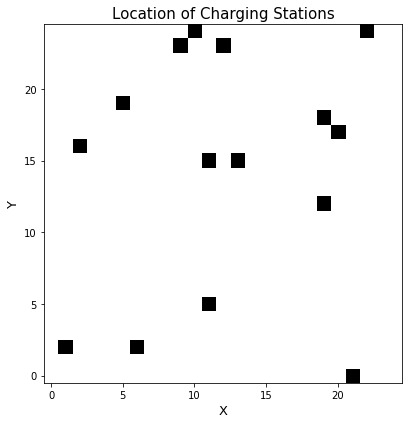

In [ ]:
# Plot the map with the location of all charging stations
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(m.map, cmap = 'binary')
ax.invert_yaxis()
ax.set_title('Location of Charging Stations', fontsize = 15)
ax.set_xlabel('X', fontsize = 13)
ax.set_ylabel('Y', fontsize = 13)
fig.tight_layout()
fig.show()

In [ ]:
# Generate the wait time distribution with hour for each charging station
m.generate_wait_time_distribution_per_charger(prob_peak_hour=[1/24] * 24 , list_sd_hours=[3,4], list_peak_wait_time=[20,25,30], prob_peak_wait_time=[0.3,0.4,0.3])

In [ ]:
# Sample an origin-destination pair
o, d = np.random.choice(np.arange(m.X * m.Y), 2)
date = datetime.fromisoformat("2020-03-01-09")

In [ ]:
m.create_journey(origin=o, destination=d, start_time=date, start_soc=0.8, desired_soc=0.5, vehicle_range=180)

In [ ]:
# Initialize the position rewards based on origin-destination
m.initialize_position_rewards(0.1, 2)

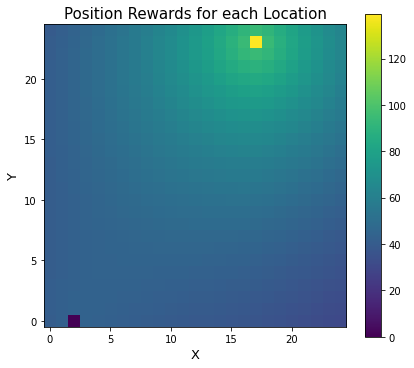

In [ ]:
# Plot the position rewards for each location
# Test out various hyperparameter choices and how they influence the position rewards
fig, ax1 = plt.subplots(figsize=(6, 6))

pos = ax1.imshow(m.position_reward.T)
ax1.invert_yaxis()
ax1.set_title('Position Rewards for each Location', fontsize = 15)
ax1.set_xlabel('X', fontsize = 13)
ax1.set_ylabel('Y', fontsize = 13)
fig.tight_layout()
fig.colorbar(pos, ax=ax1, shrink=0.9)
fig.show()

In [ ]:
# Get the optimal policy/route using value iteration approach
policy = m.value_iteration(num_iterations=5, discount_factor=0.9)

Maximum steps reached!!


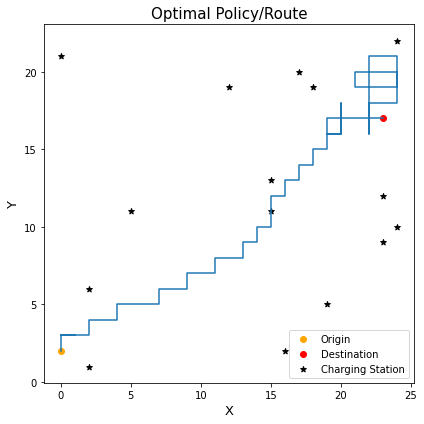

In [ ]:
# Plot the route
fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot the route using actions
ax1.plot(policy[0], policy[1])

# Plot the origin
o_x, o_y = np.unravel_index(o, m.map_shape)
ax1.scatter(o_x, o_y, color = 'orange', label = 'Origin')

# Plot the destination
d_x, d_y = np.unravel_index(d, m.map_shape)
ax1.scatter(d_x, d_y, color = 'red', label = 'Destination')

# Plot the charging stations
c_x, c_y = np.unravel_index(m.charging_stations, m.map_shape)
ax1.scatter(c_x, c_y, color = 'black', label = 'Charging Station', marker = '*')

ax1.set_title('Optimal Policy/Route', fontsize = 15)
ax1.set_xlabel('X', fontsize = 13)
ax1.set_ylabel('Y', fontsize = 13)
ax1.legend()
fig.tight_layout()
fig.show()

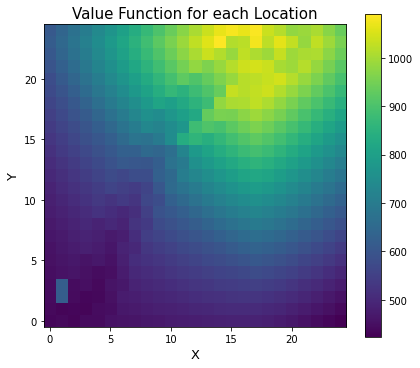

In [ ]:
# Plot the value function for each location
# Test out various hyperparameter choices and how they influence the position rewards
fig, ax1 = plt.subplots(figsize=(6, 6))

pos = ax1.imshow(m.value_function.T)
ax1.invert_yaxis()
ax1.set_title('Value Function for each Location', fontsize = 15)
ax1.set_xlabel('X', fontsize = 13)
ax1.set_ylabel('Y', fontsize = 13)
fig.tight_layout()
fig.colorbar(pos, ax=ax1, shrink=0.9)
fig.show()

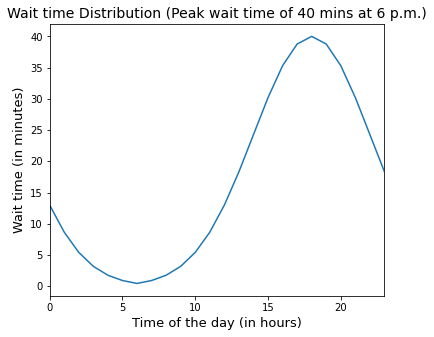

In [ ]:
# Sample plot for truncnorm distribution

peak = 18 # enter any peak hour value from [0, 23] - if unaware, pls remember datatime stores hours from 0 to 23 :))
rv = ss.truncnorm(-12/4, 11/4, peak, 4)
prob = np.zeros(24)
for i in range(-12, 12):
    prob[(i + peak + 24) % 24] = rv.pdf(i + peak) / rv.pdf(peak) * 40

fig, ax1 = plt.subplots(figsize=(6, 5))

ax1.plot(np.arange(24), prob)
ax1.set_title('Wait time Distribution (Peak wait time of 40 mins at 6 p.m.)', fontsize = 14)
ax1.set_xlabel('Time of the day (in hours)', fontsize = 13)
ax1.set_ylabel('Wait time (in minutes)', fontsize = 13)
ax1.set_xlim([0,23])
fig.show()